In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

file_path = "data/noemoticon_preprocessed.csv"
df = pd.read_csv(file_path)
print(df.info())

label_mapping = {0: 0, 4: 1} #把原始的 0/4 映射成 0/1，实现 二分类任务
df["polarity"] = df["polarity"].map(label_mapping)

Using device: cuda
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597267 entries, 0 to 1597266
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1597267 non-null  int64 
 1   text      1597267 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB
None


In [3]:
df["tokens"] = df["text"].apply(word_tokenize) #base on the experience, directly use nftk's word_tokenize

In [4]:
counter = Counter()
for tokens in df["tokens"]:
    counter.update(tokens)

max_vocab_size = 50000
word2idx = {"<PAD>": 0, "<UNK>": 1}
for i, (word, freq) in enumerate(counter.most_common(max_vocab_size - 2), start=2):
    word2idx[word] = i

def tokens_to_ids(tokens, word2idx):
    return [word2idx.get(token, word2idx["<UNK>"]) for token in tokens]

df["token_ids"] = df["tokens"].apply(lambda x: tokens_to_ids(x, word2idx))

train_x, test_x, train_y, test_y = train_test_split(
    df["token_ids"], df["polarity"], test_size=0.2, random_state=42, stratify=df["polarity"]
)

In [5]:
# Define dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)


In [6]:
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts = pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.long)
    return texts, labels

In [7]:
# **创建 DataLoader**
batch_size = 128
train_dataset = TextDataset(train_x.tolist(), train_y.tolist())
test_dataset = TextDataset(test_x.tolist(), test_y.tolist())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [8]:
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, num_filters=100, kernel_sizes=(3, 4, 5)):
        super(CNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=k) for k in kernel_sizes
        ])
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)
        
    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = [F.relu(conv(x)).max(dim=2)[0] for conv in self.convs]
        x = torch.cat(x, dim=1)
        return self.fc(x)

In [9]:
class CNN_LSTM_Classifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, hidden_dim=128, num_layers=1):
        super(CNN_LSTM_Classifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim, 100, kernel_size=3)
        self.lstm = nn.LSTM(100, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = F.relu(self.conv(x)).permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.fc(x)

In [10]:
class CNN_GRU_Classifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, hidden_dim=128, num_layers=1):
        super(CNN_GRU_Classifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim, 100, kernel_size=3)
        self.gru = nn.GRU(100, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = F.relu(self.conv(x)).permute(0, 2, 1)
        x, _ = self.gru(x)
        x = x[:, -1, :]
        return self.fc(x)

In [11]:
def train_model(model, train_loader, test_loader, num_epochs=10, lr=0.0001, device='cuda'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
        for inputs, labels in train_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            
            train_progress.set_postfix(loss=f"{loss.item():.4f}")
        
        train_acc = correct / total
        train_loss /= len(train_loader)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        
        val_progress = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                predictions = torch.argmax(outputs, dim=1)
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
                
                val_progress.set_postfix(loss=f"{loss.item():.4f}")
        
        val_acc = val_correct / val_total
        val_loss /= len(test_loader)
        
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return history

In [12]:
# Function to plot results
def plot_results(history, title):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    num_epochs = len(history['train_loss'])
    x_ticks = list(range(1, num_epochs + 1))
    
    # Plot Loss
    axes[0].plot(x_ticks, history['train_loss'], label='Train Loss')
    axes[0].plot(x_ticks, history['val_loss'], label='Val Loss', linestyle='dashed')
    axes[0].set_xticks(x_ticks)
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'Training Loss ({title})')
    axes[0].legend()
    
    # Plot Accuracy
    axes[1].plot(x_ticks, [x * 100 for x in history['train_acc']], label='Train Acc')
    axes[1].plot(x_ticks, [x * 100 for x in history['val_acc']], label='Val Acc', linestyle='dashed')
    axes[1].set_xticks(x_ticks)
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'Validation Accuracy ({title})')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

Epoch 1/10: Train Loss: 0.4815, Train Acc: 0.7661, Val Loss: 0.4416, Val Acc: 0.7927


Epoch 2/10: Train Loss: 0.4145, Train Acc: 0.8095, Val Loss: 0.4194, Val Acc: 0.8065


Epoch 3/10: Train Loss: 0.3880, Train Acc: 0.8253, Val Loss: 0.4116, Val Acc: 0.8112


Epoch 4/10: Train Loss: 0.3693, Train Acc: 0.8359, Val Loss: 0.4101, Val Acc: 0.8122


Epoch 5/10: Train Loss: 0.3542, Train Acc: 0.8444, Val Loss: 0.4095, Val Acc: 0.8140


Epoch 6/10: Train Loss: 0.3412, Train Acc: 0.8512, Val Loss: 0.4096, Val Acc: 0.8156


Epoch 7/10: Train Loss: 0.3300, Train Acc: 0.8571, Val Loss: 0.4146, Val Acc: 0.8151


Epoch 8/10: Train Loss: 0.3196, Train Acc: 0.8628, Val Loss: 0.4204, Val Acc: 0.8124


Epoch 9/10: Train Loss: 0.3099, Train Acc: 0.8677, Val Loss: 0.4215, Val Acc: 0.8131


Epoch 10/10: Train Loss: 0.3007, Train Acc: 0.8726, Val Loss: 0.4267, Val Acc: 0.8122


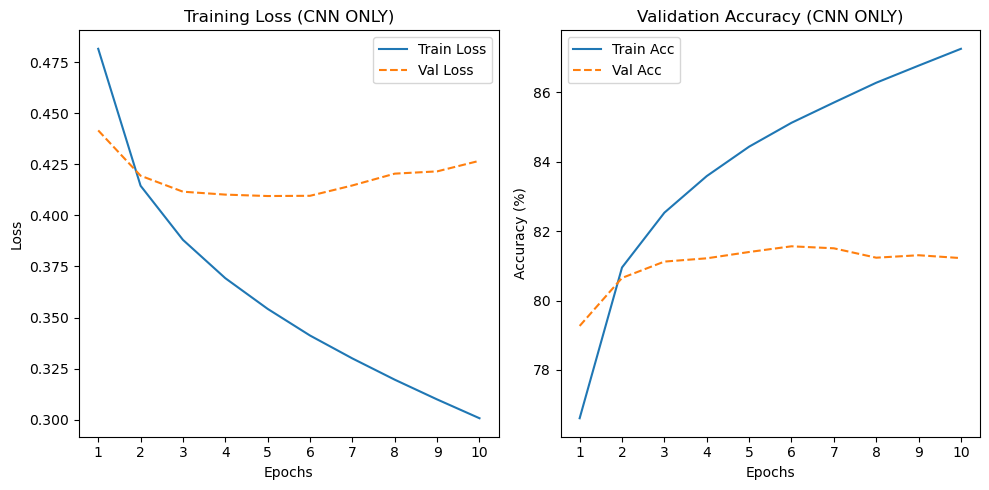

In [13]:
cnn_model = CNNClassifier(len(word2idx), embed_dim=128, num_classes=2).to(device)
history = train_model(cnn_model, train_loader, test_loader)
plot_results(history, 'CNN ONLY')

Epoch 1/10: Train Loss: 0.5060, Train Acc: 0.7421, Val Loss: 0.4454, Val Acc: 0.7909


Epoch 2/10: Train Loss: 0.4239, Train Acc: 0.8034, Val Loss: 0.4155, Val Acc: 0.8080


Epoch 3/10: Train Loss: 0.3989, Train Acc: 0.8182, Val Loss: 0.4064, Val Acc: 0.8138


Epoch 4/10: Train Loss: 0.3835, Train Acc: 0.8270, Val Loss: 0.3978, Val Acc: 0.8186


Epoch 5/10: Train Loss: 0.3715, Train Acc: 0.8341, Val Loss: 0.3894, Val Acc: 0.8249


Epoch 6/10: Train Loss: 0.3624, Train Acc: 0.8388, Val Loss: 0.3864, Val Acc: 0.8257


Epoch 7/10: Train Loss: 0.3544, Train Acc: 0.8432, Val Loss: 0.3849, Val Acc: 0.8280


Epoch 8/10: Train Loss: 0.3475, Train Acc: 0.8467, Val Loss: 0.3795, Val Acc: 0.8299


Epoch 9/10: Train Loss: 0.3413, Train Acc: 0.8502, Val Loss: 0.3791, Val Acc: 0.8312


Epoch 10/10: Train Loss: 0.3356, Train Acc: 0.8530, Val Loss: 0.3800, Val Acc: 0.8311


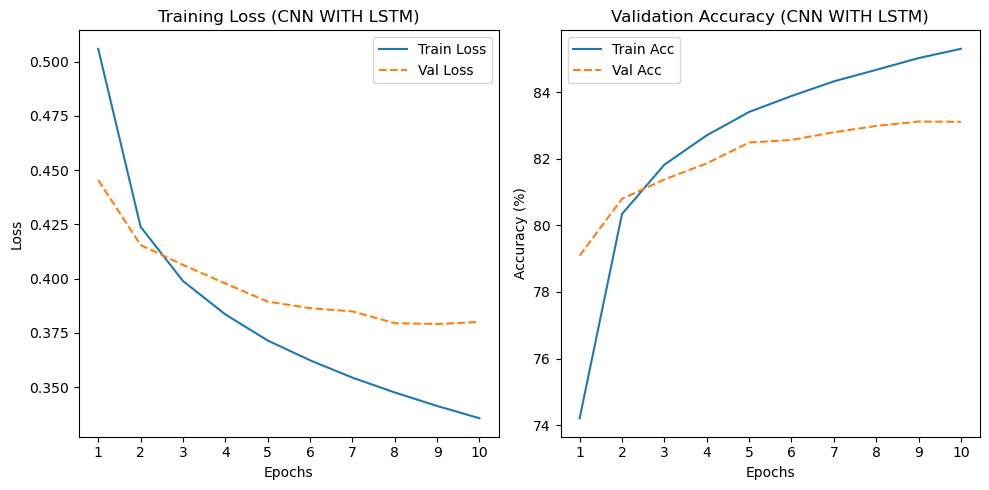

In [14]:
cnn_lstm_model = CNN_LSTM_Classifier(len(word2idx), embed_dim=128, hidden_dim=64, num_classes=2).to(device)
history = train_model(cnn_lstm_model, train_loader, test_loader)
plot_results(history, 'CNN WITH LSTM')

Epoch 1/10: Train Loss: 0.4935, Train Acc: 0.7540, Val Loss: 0.4386, Val Acc: 0.7954


Epoch 2/10: Train Loss: 0.4188, Train Acc: 0.8073, Val Loss: 0.4124, Val Acc: 0.8112


Epoch 3/10: Train Loss: 0.3950, Train Acc: 0.8210, Val Loss: 0.4056, Val Acc: 0.8144


Epoch 4/10: Train Loss: 0.3800, Train Acc: 0.8294, Val Loss: 0.3934, Val Acc: 0.8220


Epoch 5/10: Train Loss: 0.3686, Train Acc: 0.8356, Val Loss: 0.3874, Val Acc: 0.8254


Epoch 6/10: Train Loss: 0.3595, Train Acc: 0.8404, Val Loss: 0.3831, Val Acc: 0.8276


Epoch 7/10: Train Loss: 0.3517, Train Acc: 0.8447, Val Loss: 0.3826, Val Acc: 0.8275


Epoch 8/10: Train Loss: 0.3450, Train Acc: 0.8481, Val Loss: 0.3771, Val Acc: 0.8315


Epoch 9/10: Train Loss: 0.3389, Train Acc: 0.8514, Val Loss: 0.3787, Val Acc: 0.8313


Epoch 10/10: Train Loss: 0.3335, Train Acc: 0.8544, Val Loss: 0.3757, Val Acc: 0.8323


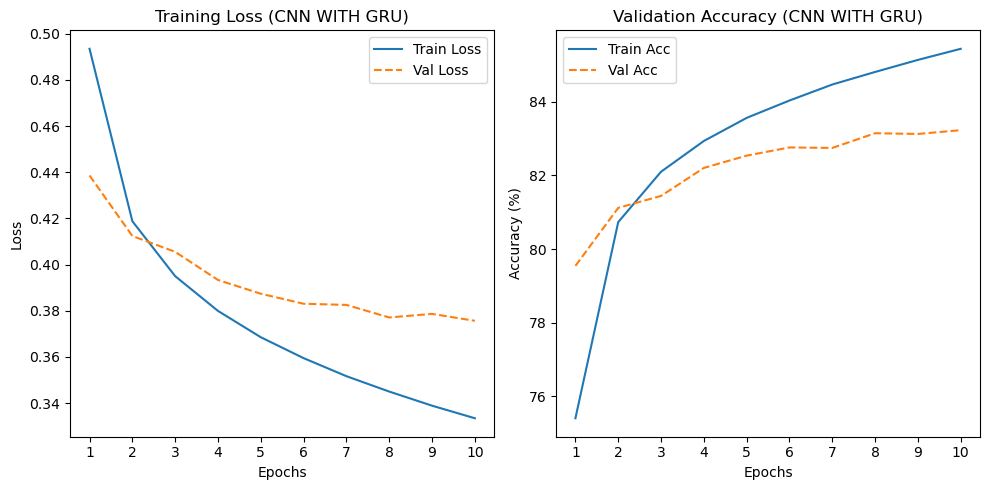

In [15]:
cnn_gru_model = CNN_GRU_Classifier(len(word2idx), embed_dim=128,hidden_dim=64, num_classes=2).to(device)
history = train_model(cnn_gru_model, train_loader, test_loader)
plot_results(history, 'CNN WITH GRU')